Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-11 20:55:33.329934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 20:55:33.330613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/27


2022-12-11 20:55:34.334258: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-11 20:55:34.789987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1421/1421 [==============================] - ETA: 0s - loss: 1.7521 - accuracy: 0.3158

2022-12-11 20:56:28.578665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1421/1421 [==============================] - 56s 37ms/step - loss: 1.7521 - accuracy: 0.3158 - val_loss: 1.4844 - val_accuracy: 0.4540
Epoch 2/27
1421/1421 [==============================] - 51s 36ms/step - loss: 1.3887 - accuracy: 0.4706 - val_loss: 1.2594 - val_accuracy: 0.5343
Epoch 3/27
1421/1421 [==============================] - 50s 35ms/step - loss: 1.1793 - accuracy: 0.5542 - val_loss: 1.1459 - val_accuracy: 0.5672
Epoch 4/27
1421/1421 [==============================] - 51s 36ms/step - loss: 1.0380 - accuracy: 0.6055 - val_loss: 1.0118 - val_accuracy: 0.6213
Epoch 5/27
1421/1421 [==============================] - 53s 38ms/step - loss: 0.9265 - accuracy: 0.6504 - val_loss: 0.9590 - val_accuracy: 0.6551
Epoch 6/27
1421/1421 [==============================] - 53s 37ms/step - loss: 0.8229 - accuracy: 0.6944 - val_loss: 0.9143 - val_accuracy: 0.6585
Epoch 7/27
1421/1421 [==============================] - 54s 38ms/step - loss: 0.7280 - accuracy: 0.7335 - val_loss: 0.9039 - val_accura

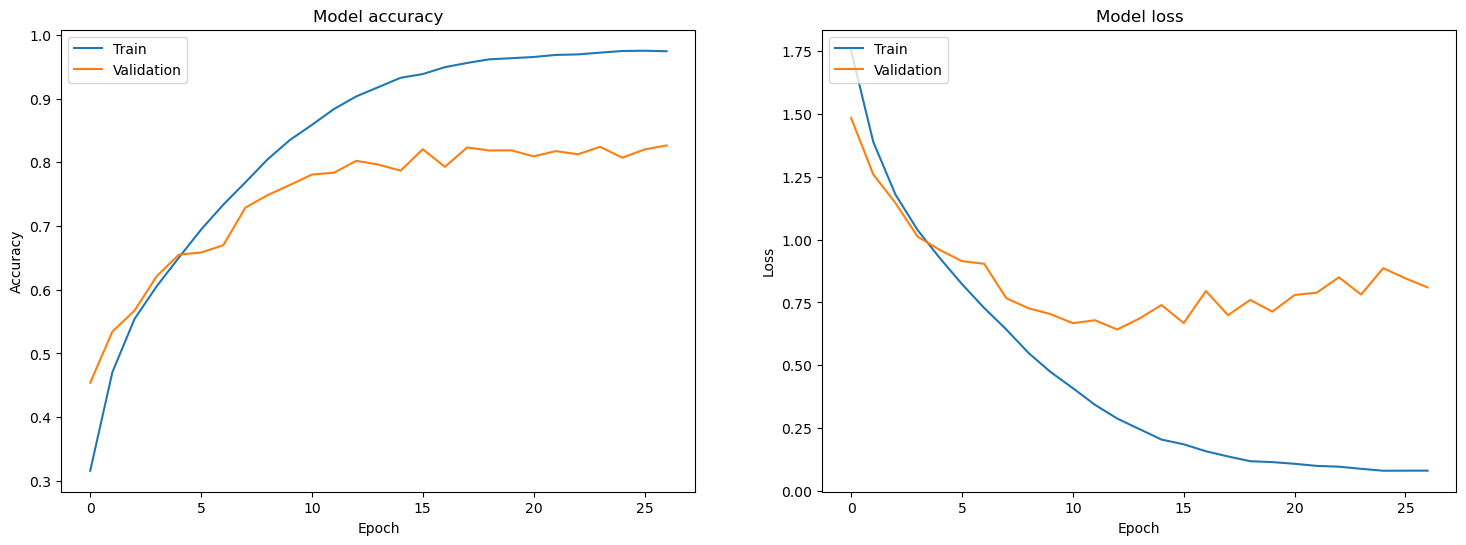

In [2]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

data = pd.read_csv('/Users/anuhyakalvakala/Downloads/train.csv')

pixel_data = data['pixels']
label_data = data['emotion']


def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)
  return X

oversampler = RandomOverSampler(sampling_strategy='auto')
X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)
X_over_series = pd.Series(X_over.flatten())

X = preprocess_pixels(X_over_series)
Y = Y_over
Y = Y_over.values.reshape(Y.shape[0],1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)


def emotion_recognition(input_shape):

  X_input = Input(input_shape)

  X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

 

  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)
  X = Dense(200, activation='relu')(X)
  X = Dropout(0.6)(X)
  X = Dense(7, activation = 'softmax')(X)

  model = Model(inputs=X_input, outputs=X)

  return model


model = emotion_recognition((48,48,1))
adam = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)
cnn = model.fit(X_train, y_train, epochs = 27, validation_data=(X_test, y_test))

# import pickle
# pickle.dump(model,open('/Users/anuhyakalvakala/Downloads/model_cnn_td_2.pkl','wb'))
model.save('/Users/anuhyakalvakala/Downloads/model_cnn_td_2.h5')

fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(cnn.history['accuracy'])
axes[0].plot(cnn.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(cnn.history['loss'])
axes[1].plot(cnn.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

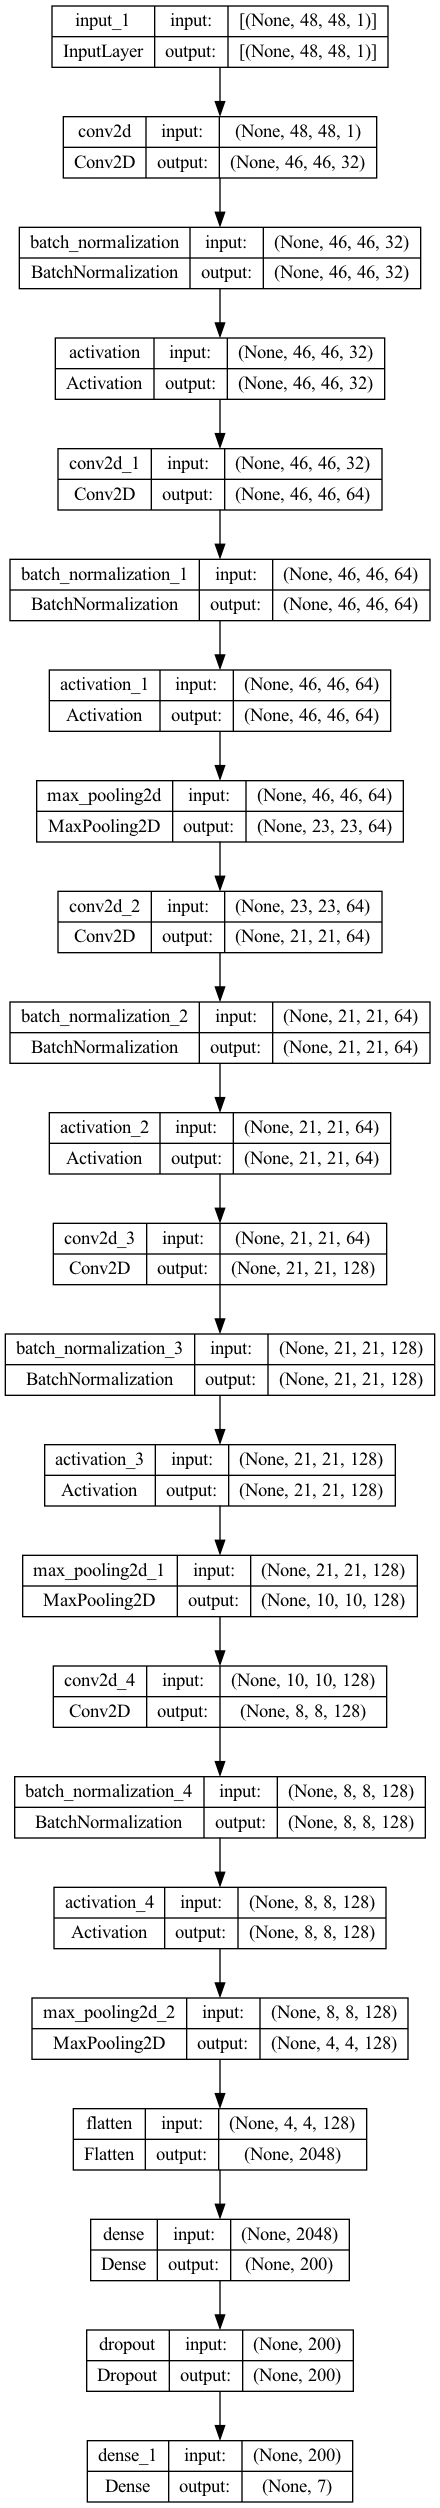

In [3]:
import tensorflow as tf

import keras
from keras.utils.vis_utils import plot_model

to_file='/Users/anuhyakalvakala/Desktop/model.png'
tf.keras.utils.plot_model (model, to_file , show_shapes = True, show_layer_names = True)

In [4]:
Y_train

array([[5],
       [4],
       [0],
       ...,
       [2],
       [3],
       [2]])

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from keras import layers
import tensorflow as tf
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns

In [6]:
predictions = model.predict(X_test).argmax(axis=1)
#pred_prob = model.predict_proba(X_test)
predict_prob=model.predict(X_test)
predict_classes=np.argmax(predict_prob,axis=1)
new_y_test = Y_test.argmax(axis=1)#.astype(int)
#print(predict_prob)
#accuracy
accuracy=accuracy_score(y_true=new_y_test, y_pred=predictions)
print('Accuracy of neural network',accuracy)

  7/158 [>.............................] - ETA: 1s 

2022-12-11 21:30:19.716385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 2s 10ms/step
Accuracy of neural network 0.14591170065333597


/Users/anuhyakalvakala/miniforge3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anuhyakalvakala/miniforge3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anuhyakalvakala/miniforge3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

              precision    recall  f1-score   support

           0       1.00      0.16      0.27      5051
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.16      5051
   macro avg       0.14      0.02      0.04      5051
weighted avg       1.00      0.16      0.27      5051

Confusion Matrix of neural networks
[[797 700 649 807 375 821 902]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


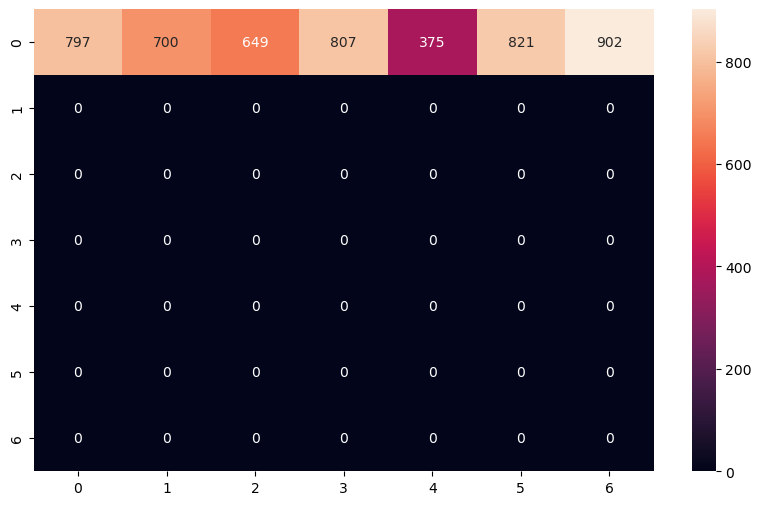

In [57]:
#confusion matrix
matrix = confusion_matrix(new_y_test, predictions)
print(classification_report(new_y_test, predictions))
print('Confusion Matrix of neural networks')
print(matrix)
# plt.figure()
# plot_confusion_matrix(matrix,new_y_test,X)
# plt.show()
fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_title('Confusion Matrx for neural network')
# ax.set_xlabel('Time label')
# ax.set_ylabel('predicted label')
plt.xlabel('Time label', axes=ax)
plt.ylabel('predicted label', axes=ax)

f = sns.heatmap(matrix, annot=True, fmt='d')

In [7]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

158/158 [==============================] - 2s 10ms/step
CNN Model Accuracy on test set: 0.8266


In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                           

In [14]:
import keras.utils as image

1/1 [==============================] - 0s 70ms/step
The predicted emotion is : Happiness


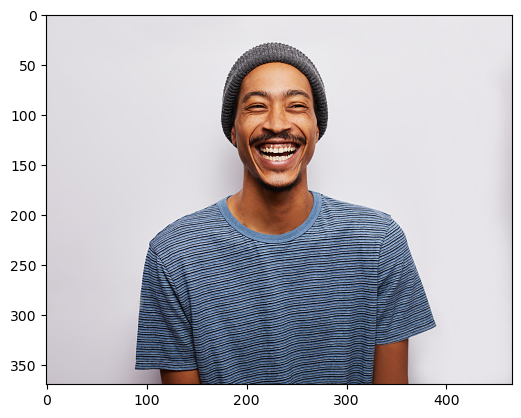

In [50]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

img_path = '/Users/anuhyakalvakala/Downloads/happy.jpg'#stories-img/image1.png'
img = tf.keras.utils.load_img(img_path, grayscale=True, target_size=(48,48))

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = np.argmax(model.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = tf.keras.utils.load_img(img_path)
plt.imshow(my_image)

1/1 [==============================] - 0s 23ms/step
The predicted emotion is : Angry


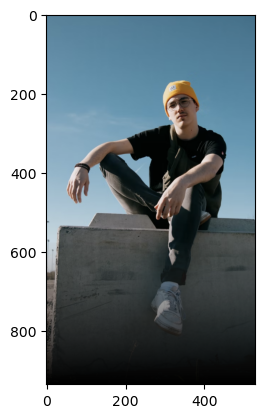

In [17]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

img_path = '/Users/anuhyakalvakala/Downloads/stories-img/image1.png'
img = tf.keras.utils.load_img(img_path, grayscale=True, target_size=(48,48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = np.argmax(model1.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

In [6]:
from keras.models import load_model
import pickle
import tensorflow as tf

1/1 [==============================] - 0s 144ms/step
[[0.82385343 0.00133086 0.00219735 0.09483594 0.03925569 0.00421188
  0.03431488]]
0 prediction
The predicted emotion is : Angry


/Users/anuhyakalvakala/miniforge3/envs/ds/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
2022-12-08 18:41:07.351509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


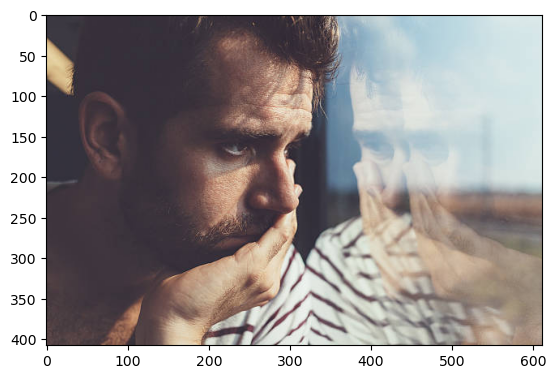

In [42]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
model1 = load_model('/Users/anuhyakalvakala/Downloads/model_cnn_td_2.h5')


img_path = '/Users/anuhyakalvakala/Downloads/.png'#stories-img/image1.png'
img = tf.keras.utils.load_img(img_path, grayscale=True, target_size=(48,48))
img = image.img_to_array(img)
#print(img)
img = np.expand_dims(x, axis=0)
img = img.reshape(1, 48, 48, 1)
    # Prepare it as pixel data
img = img.astype('float32')
img = (img / 255.0)*10
#print(img)
k= model1.predict(img)
print(k)
prediction = np.argmax(k)
print(prediction,'prediction')


#prediction = np.argmax(model1.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

In [11]:
img= '/Users/anuhyakalvakala/Downloads/stories-img/image1.png'
model1 = load_model('/Users/anuhyakalvakala/Downloads/model_cnn_td_2.h5')
class_prediction = model1.predict(img)
print(class_prediction)

IndexError: tuple index out of range

In [10]:

preds=model1.predict(img)
np.argmax(preds)

IndexError: tuple index out of range

In [16]:
image= '/Users/anuhyakalvakala/Downloads/stories-img/image1.png'
# class_prediction = model1.predict()
# print(class_prediction)
image = tf.expand_dims(image, axis=0)   # the shape would be (1, 224, 224, 3)
print(model1.predict(image)[0])

2022-12-06 15:11:54.903871: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/anuhyakalvakala/miniforge3/envs/virenv/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/anuhyakalvakala/miniforge3/envs/virenv/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/anuhyakalvakala/miniforge3/envs/virenv/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/anuhyakalvakala/miniforge3/envs/virenv/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/anuhyakalvakala/miniforge3/envs/virenv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/anuhyakalvakala/miniforge3/envs/virenv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_3" (type Sequential).
    
    Input 0 of layer "conv2d_18" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None


In [14]:
cnn.history

In [28]:
file = 'image1.png'
        # try:
            #if file and allowed_file(file.filename):
filename = file.filename
print(filename)

AttributeError: 'str' object has no attribute 'filename'

TypeError: 'NoneType' object is not subscriptable

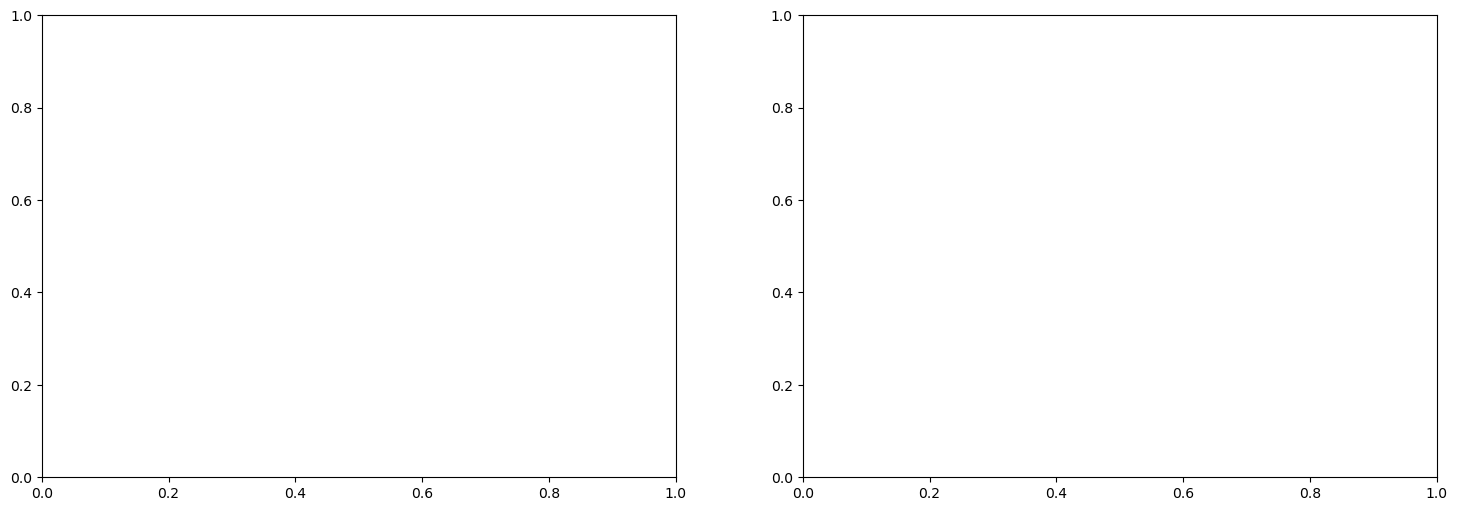

In [12]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(cnn.history['accuracy'])
axes[0].plot(cnn.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(cnn.history['loss'])
axes[1].plot(cnn.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()